In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


C:\Users\User\anaconda3\envs\ganzer\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Customlabel', ylabel='count'>

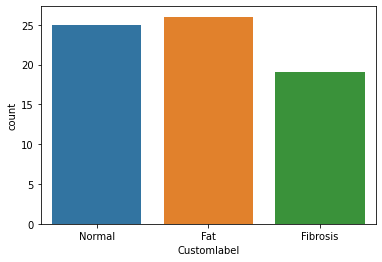

In [4]:
data = pd.read_csv('C:\\Users\\User\\Desktop\\kmeans\\dataset_norm.csv')
data.head()
#############################################
radiofeature = data.loc[:, 'ADC(10-3mm2/s)':'Kpa']
label = data['Customlabel']
radiofeature.insert(0, "Customlabel", label, True)
radiofeature['Customlabel'] = radiofeature['Customlabel'].map({'Normal': 0, 'Fat': 1, 'Fibrosis': 2})
radiofeature.head()

#################################################
sns.countplot(data['Customlabel'])

In [5]:
train, test = train_test_split(radiofeature, test_size=0.2, random_state=2019)

x_train = train.drop(['Customlabel'], axis=1)
y_train = train.Customlabel

x_test = test.drop(['Customlabel'], axis=1)
y_test = test.Customlabel

print(len(train), len(test))

56 14


## Accuracy comparison according to the ML Models

In [6]:
#%%
#SVM
model = svm.SVC(gamma='scale')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print('SVM: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

#%%
#DecisionTree
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print('DecisionTreeClassifier: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

#%%
#KNeighbors
model = KNeighborsClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print('KNeighborsClassifier: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

#%%
#LogisticRegression
model = LogisticRegression(solver='lbfgs', max_iter=2000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print('LogisticRegression: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))

#%%
#RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print('RandomForestClassifier: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))


SVM: 100.00
DecisionTreeClassifier: 100.00
KNeighborsClassifier: 100.00
LogisticRegression: 100.00
RandomForestClassifier: 100.00


## Feature selection

In [7]:
features = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

print(features)

FF(%)              0.282530
Kpa                0.272927
ADC(10-3mm2/s)     0.124634
D(10^-3)           0.081876
Kapp               0.081286
Dapp(10-3mm2/s)    0.062445
f(%)               0.047159
D*(10-3mm2/s)      0.047142
dtype: float64


In [25]:
# Extract Top 5 Features
top_5_features = features.keys()[[0, 2]]
print(top_5_features)


Index(['FF(%)', 'ADC(10-3mm2/s)'], dtype='object')


In [26]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

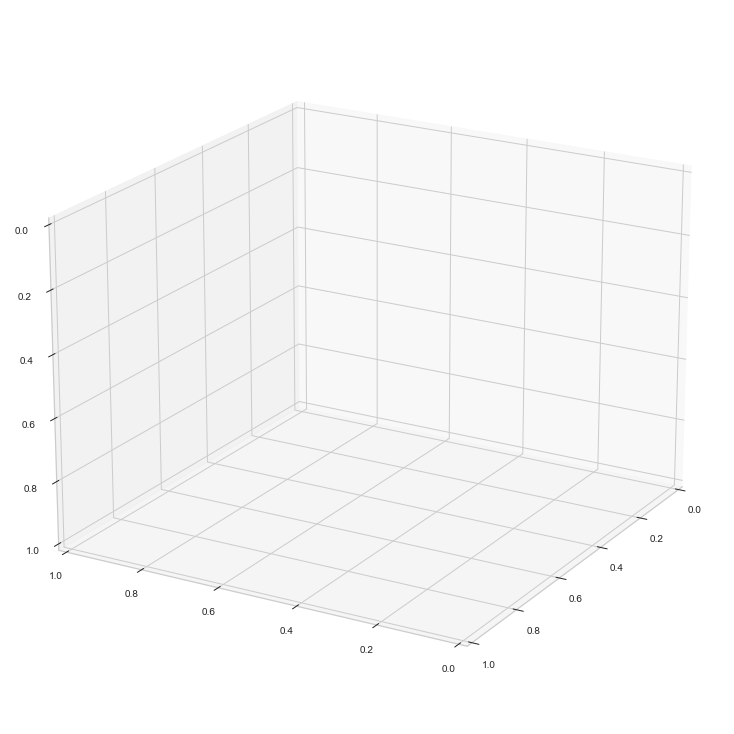

In [27]:
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig, elev=-160, azim=150)
X_reduced = PCA(n_components=3).fit_transform(radiofeature.loc[:, top_5_features])
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=radiofeature['Customlabel'], cmap=plt.cm.Set1, edgecolor='k', s=70)
ax.set_title("MR Liver")
ax.set_xlabel("x")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("y")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("z")
ax.w_zaxis.set_ticklabels([])

plt.show()

## Accuracy comparison according to the ML Models with Top 5 features

In [31]:
models = {
    'SVM': svm.SVC(gamma='scale'),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter=2000),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=1000)
    }


for name, model in models.items():
    model.fit(x_train[top_5_features], y_train)
    y_pred = model.predict(x_test[top_5_features])
    print('%s: %.2f' % (name, (metrics.accuracy_score(y_pred, y_test) * 100)))


SVM: 92.86
DecisionTreeClassifier: 85.71
KNeighborsClassifier: 92.86
LogisticRegression: 85.71
RandomForestClassifier: 92.86


In [32]:
model = RandomForestClassifier(n_estimators=100)
#model = KNeighborsClassifier()
#model = DecisionTreeClassifier()
model.fit(x_train[top_5_features], y_train)
y_pred = model.predict(x_test[top_5_features])

print('RandomForestClassifier: %.2f' % (metrics.accuracy_score(y_pred, y_test) * 100))


RandomForestClassifier: 92.86


In [33]:
print(y_test), print(y_pred)

41    1
51    2
30    1
4     0
52    2
49    1
14    0
13    0
55    2
9     0
0     0
60    2
2     0
47    1
Name: Customlabel, dtype: int64
[1 0 1 0 2 1 0 0 2 0 0 2 0 1]


(None, None)

In [34]:
clf = ['Normal', 'Fat', 'Fibrosis']

In [35]:
inp = np.array(y_test)
oup = np.array(y_pred)

## Classification Test

In [36]:
for i in range(len(inp)):
    print('input : ' + clf[inp[i]] + '  ----------->  output : ' + clf[oup[i]])

input : Fat  ----------->  output : Fat
input : Fibrosis  ----------->  output : Normal
input : Fat  ----------->  output : Fat
input : Normal  ----------->  output : Normal
input : Fibrosis  ----------->  output : Fibrosis
input : Fat  ----------->  output : Fat
input : Normal  ----------->  output : Normal
input : Normal  ----------->  output : Normal
input : Fibrosis  ----------->  output : Fibrosis
input : Normal  ----------->  output : Normal
input : Normal  ----------->  output : Normal
input : Fibrosis  ----------->  output : Fibrosis
input : Normal  ----------->  output : Normal
input : Fat  ----------->  output : Fat


In [37]:
import pickle

pkl_filename = "C:/Users/User/Desktop/MM_Radiomics/Trained model weight.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [38]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [39]:
y_pred = pickle_model.predict(x_test[top_5_features])

print('%s: %.2f' % (name, (metrics.accuracy_score(y_pred, y_test) * 100)))

clf = ['Normal', 'Fat', 'Fibrosis']
inp = np.array(y_test)
oup = np.array(y_pred)

for i in range(len(inp)):
    print('input : ' + clf[inp[i]] + '  ----------->  output : ' + clf[oup[i]])

RandomForestClassifier: 92.86
input : Fat  ----------->  output : Fat
input : Fibrosis  ----------->  output : Normal
input : Fat  ----------->  output : Fat
input : Normal  ----------->  output : Normal
input : Fibrosis  ----------->  output : Fibrosis
input : Fat  ----------->  output : Fat
input : Normal  ----------->  output : Normal
input : Normal  ----------->  output : Normal
input : Fibrosis  ----------->  output : Fibrosis
input : Normal  ----------->  output : Normal
input : Normal  ----------->  output : Normal
input : Fibrosis  ----------->  output : Fibrosis
input : Normal  ----------->  output : Normal
input : Fat  ----------->  output : Fat


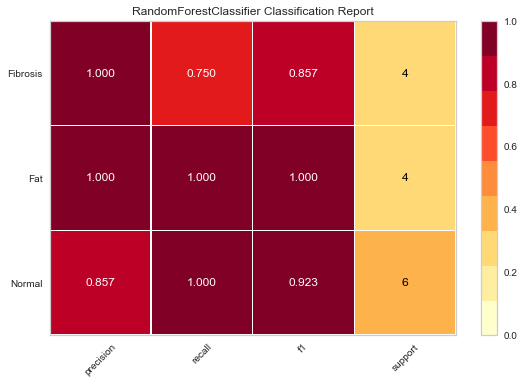

In [40]:
from yellowbrick.classifier import ClassificationReport

vizualizer = ClassificationReport(model, classes=clf, support=True)
vizualizer.fit(x_train.loc[:, top_5_features], y_train)
vizualizer.score(x_test.loc[:, top_5_features], y_test)
vizualizer.show();

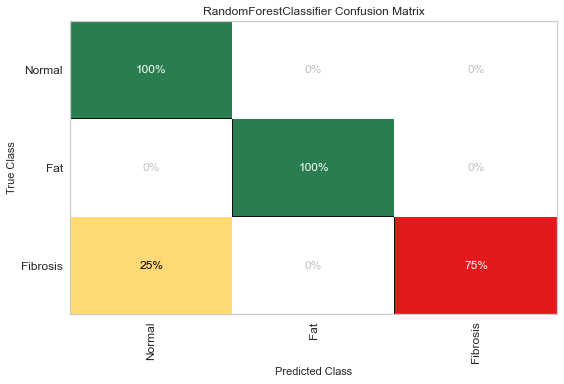

In [41]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(model, classes=clf, percent=True) #label_encoder={0: 'Normal', 1: 'Fat', 2: 'Fibrosis'}
cm.fit(x_train.loc[:, top_5_features], y_train)
cm.score(x_test.loc[:, top_5_features], y_test)
cm.show();

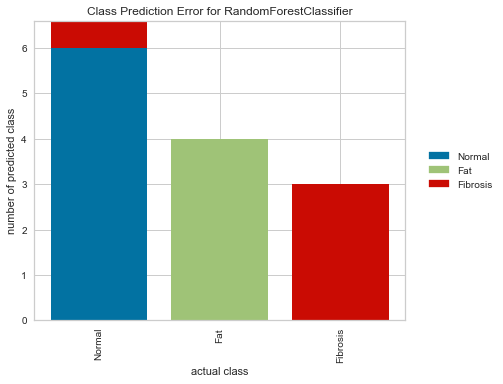

In [42]:
from yellowbrick.classifier import ClassPredictionError
visualizer = ClassPredictionError(model, classes=clf)
visualizer.fit(x_train.loc[:, top_5_features], y_train)
visualizer.score(x_test.loc[:, top_5_features], y_test)
visualizer.show();

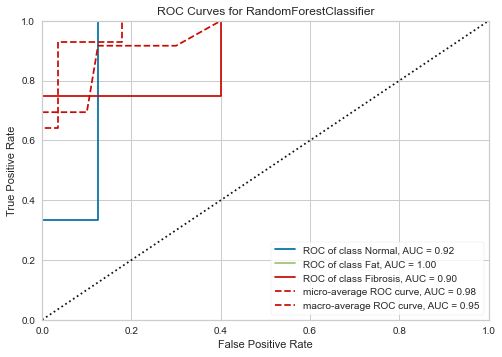

In [43]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(model, classes=['Normal', 'Fat', 'Fibrosis'])
visualizer.fit(x_train.loc[:, top_5_features], y_train)
visualizer.score(x_test.loc[:, top_5_features], y_test)
visualizer.show();